In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.datasets import ImageFolder

from config import *
from torch_datasets import *
from utils import (render_samples, show_batch, sorted_paths, show_img, 
                   read_img, plot_output)

In [44]:
class Sketch2PixDS(Dataset):
    
    def __init__(self, path, type_):
        """
        Parameters
        -----------
        type_: str
            'photo' or 'sketch'
        """
        if type_ == 'photo':
            file_type = '.jpg'
        elif type == 'sketch':
            file_type = '.png'
        self.paths = list(path.rglob(f'*{file_type}'))
    
    def __getitem__(self, i):
        path = self.paths[i]
        return str(path).split('/')[-2]
    
    def __len__(self):
        pass

In [11]:
path = Path('sketch_data/256x256/')
list(path.iterdir())

[PosixPath('sketch_data/256x256/.DS_Store'),
 PosixPath('sketch_data/256x256/photo'),
 PosixPath('sketch_data/256x256/sketch')]

In [30]:
photo_path = path/'photo/tx_000100000000/elephant'

In [32]:
sketch_path = path/'sketch/tx_000000000110/elephant'

In [45]:
photo_ds = Sketch2PixDS(photo_path, 'photo')

In [46]:
photo_ds[25]

'elephant'

## Shoe Dataset

In [107]:
class ShoeDataset(Dataset):
    
    def __init__(self, path, size=64):
        super().__init__()
        self.files = [str(f) for f in Path(path).iterdir()]
        self.size = size
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        img = read_img(self.files[i]) / 255
        sketch, photo = img[:, :256, :], img[:, 256:, :]
        if self.size:
            sketch = cv2.resize(sketch, (self.size, self.size), 
                                interpolation=cv2.INTER_AREA)
            photo = cv2.resize(photo, (self.size, self.size),
                               interpolation=cv2.INTER_AREA)
        return self.reorder(sketch), self.reorder(photo)
    
    def reorder(self, img):
        return np.transpose(img, (2, 0, 1))
    
    def show(self, i):
        """Display resized image."""
        fig, ax = plt.subplots(1, 2, figsize=(9, 9))
        for i, img in enumerate(self[i]):
            ax[i].axis('off')
            ax[i].imshow(np.transpose(img, (1, 2, 0)))
        plt.show()

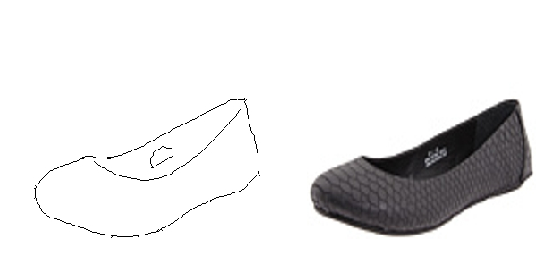

In [111]:
shoe_ds = ShoeDataset('edges2shoes/train', 256)
shoe_dl = DataLoader(shoe_ds, batch_size=32, shuffle=True)
shoe_ds.show(0)

In [112]:
batch = next(iter(shoe_dl))[0]
batch2 = np.transpose(batch, (0, 3, 1, 2))
batch.shape, batch2.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 3, 256]))

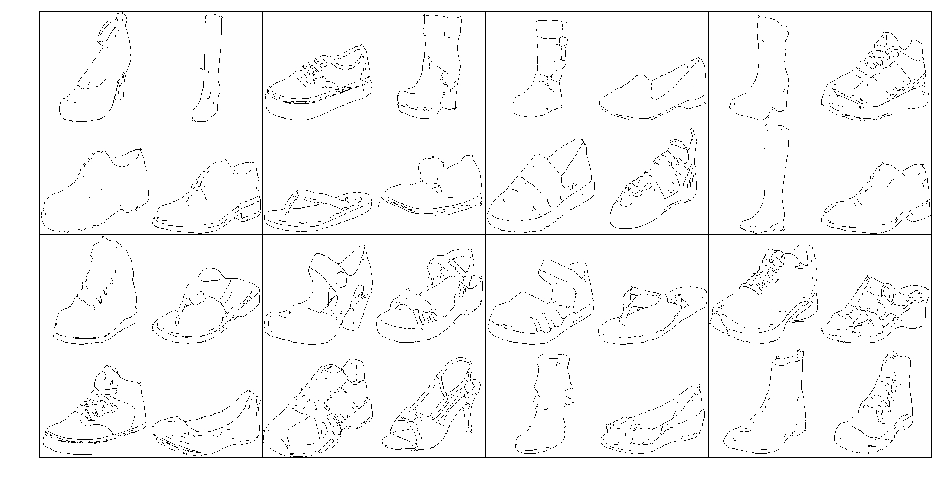

In [113]:
show_batch(shoe_dl, size=16)

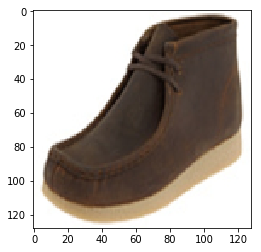

In [205]:
plt.imshow(cv2.resize(shoe_ds[2][1], (128, 128), interpolation=cv2.INTER_AREA))
    plt.show()

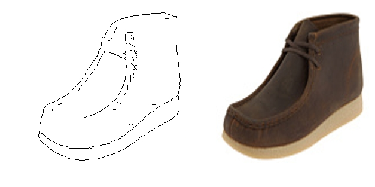

In [201]:
shoe_ds.show(2)

In [4]:
files = [str(f) for f in Path('edges2shoes/train').iterdir()]

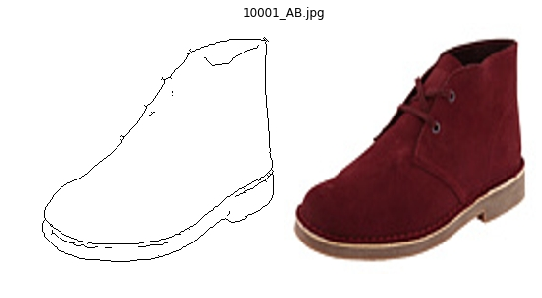

In [264]:
show_img(files[10])

In [187]:
batch = next(iter(shoe_dl))
batch[0].shape

torch.Size([64, 3, 64, 128])

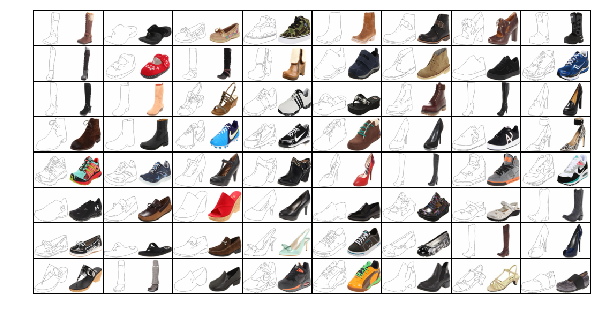

In [204]:
show_batch(shoe_dl)

In [188]:
batch[1].shape

torch.Size([64])

In [192]:
batch[1].float().mean()

tensor(0.0312)

In [61]:
class GRelu(nn.Module):
    """Generic ReLU."""
    
    def __init__(self, leak=0.0, max=float('inf'), sub=0.0):
        super().__init__()
        self.leak = leak
        self.max = max
        self.sub = sub
        
    def forward(self, x):
        """Check which operations are necessary to save computation."""
        x = F.leaky_relu(x, self.leak) if self.leak else F.relu(x)
        if self.sub:
            x -= self.sub
        if self.max:
            x = torch.clamp(x, max=self.max)
        return x
    
    def __repr__(self):
        return f'GReLU(leak={self.leak}, max={self.max}, sub={self.sub})'

In [55]:
JRelu = GRelu(leak=.1, sub=.4, max=6.0)

In [56]:
JRelu

GReLU(leak=0.1, max=6.0, sub=0.4)

In [57]:
gr = GRelu()

In [58]:
gr

GReLU(leak=0.0, max=inf, sub=0.0)

In [7]:
x = torch.randn(10000, 10000)*1.5
x

tensor([[-1.7622, -1.5283,  1.0733,  ..., -4.1463,  1.3158, -0.1394],
        [ 1.3102,  0.5818,  0.7842,  ..., -0.7559, -1.2583, -0.2745],
        [-0.1953, -0.8410,  1.5216,  ...,  1.9324,  1.3085, -0.7960],
        ...,
        [-0.0204, -1.5235, -1.1081,  ...,  0.8093,  1.9298,  0.7486],
        [-1.0593, -1.2324,  2.3774,  ..., -0.2231,  1.1648,  0.8327],
        [ 1.1468, -0.3820,  2.0590,  ..., -0.5271, -1.1870,  2.4502]])

In [30]:
def stats(x):
    """Quick wrapper to get mean and standard deviation of a tensor."""
    return round(x.mean().item(), 4), round(x.std().item(), 4)

## 3D experiments

In [7]:
x = torch.randn(4, 3, 5, 5, 5)
conv = nn.Conv3d(3, 6, kernel_size=3, stride=1, padding=1)

In [8]:
conv(x).shape

torch.Size([4, 6, 5, 5, 5])

## Generating plots for training runs that were cut short

In [5]:
output_dog3 = torch.load('dog_samples3/stats.pkl')

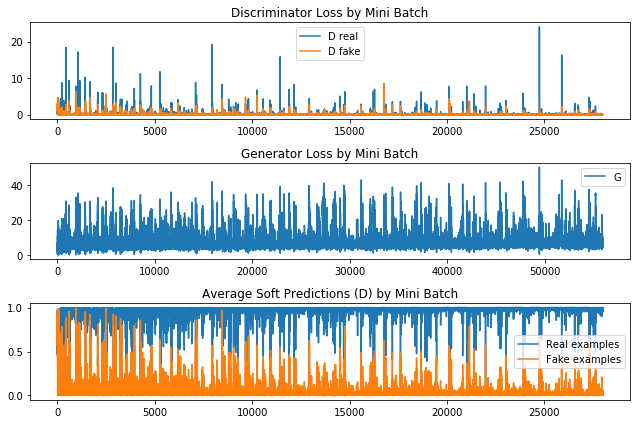

In [9]:
plot_output(output_dog3, 'dog_samples3')

MovieWriter imagemagick unavailable.


Writing file to dog_samples4/dog_samples4.gif


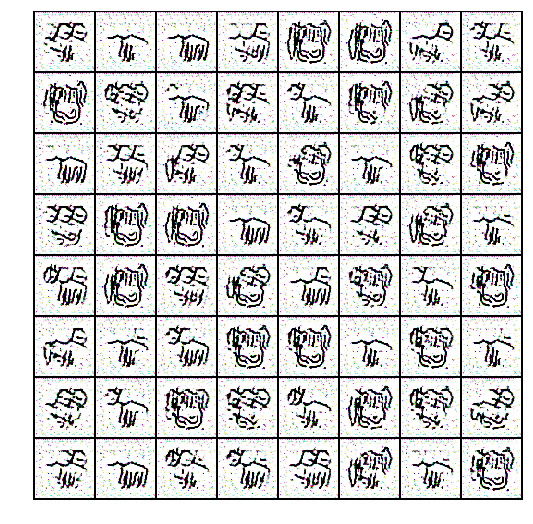

In [4]:
render_samples('dog_samples4')

MovieWriter imagemagick unavailable.


Writing file to cat_samples5/cat_samples5.gif


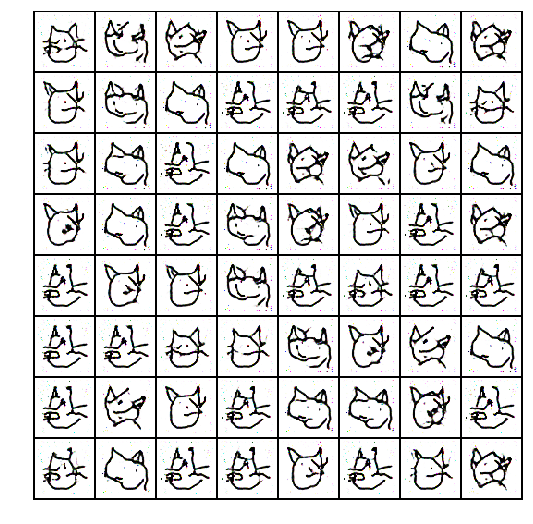

In [7]:
render_samples('cat_samples5')